# Information plane experiments (DNN classifier, MNIST)

## Preamble

In [1]:
import numpy as np

In [2]:
import torch
import torchvision

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda
Devices count: 1


In [37]:
import os
from pathlib import Path

path = Path("../../data/").resolve()
experiments_path = path / "mutual_information/MNIST/"
models_path = experiments_path / "models/"
results_path = experiments_path / "results/"

### Global settings

In [5]:
# Autoencoder for inputs.
X_latent_dim = 4             # Input dimension after compression.
X_autoencoder_n_epochs = 200 # Number of epochs to train the autoencoder.
load_X_autoencoder = True    # Reload weights of the autoencoder.

# Autoencoder for layers.
L_latent_dim = 4              # Layer dimension after compression.
L_autoencoder_n_epochs = 100  # Number of epochs to train the autoencoder.

# Classifier.
classifier_lr = 1e-5      # Classifier learning rate.
classifier_n_epochs = 300 # Number of epochs to train the classifier.
sigma = 1e-3              # Noise-to-signal ratio.

## Dataset

In [6]:
from torchvision.datasets import MNIST

In [7]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [8]:
train_dataset = MNIST(root="./.cache", download=True, transform=image_transform)
test_dataset = MNIST(root="./.cache", download=True, transform=image_transform, train=False)

In [9]:
batch_size_train = 1024
batch_size_test  = 2048

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
eval_dataloader  = test_dataloader #torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=False)

### Visualisation

In [11]:
from misc.utils import *

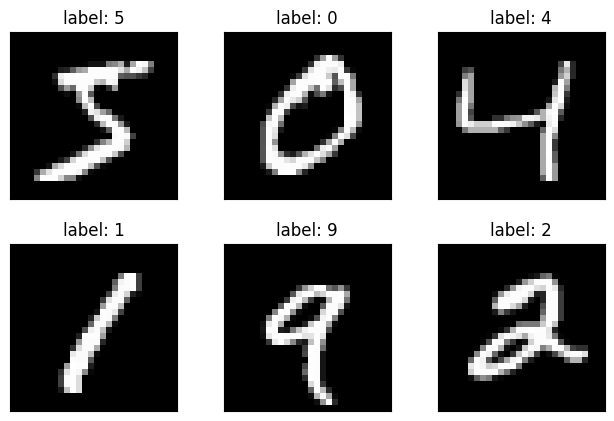

In [12]:
show_images(*split_lists([(train_dataset[index][0], f"label: {train_dataset[index][1]}") for index in range(6)]))

## Autoencoder for inputs

In [13]:
from mutinfo.torch.datasets import AutoencoderDataset

In [14]:
train_dataset_autoencoder = AutoencoderDataset(train_dataset)
test_dataset_autoencoder = AutoencoderDataset(test_dataset)

In [15]:
autoencoder_batch_size_train = 2048
autoencoder_batch_size_test  = autoencoder_batch_size_train * 2

In [16]:
train_dataloader_autoencoder = torch.utils.data.DataLoader(train_dataset_autoencoder, batch_size=autoencoder_batch_size_train, shuffle=True)
test_dataloader_autoencoder  = torch.utils.data.DataLoader(test_dataset_autoencoder, batch_size=autoencoder_batch_size_test, shuffle=False)

In [17]:
from misc.autoencoder import *

In [18]:
import random
from IPython.display import clear_output

def autoencoder_callback(autoencoder, autoencoder_metrics=None):
    clear_output(True)
    
    was_in_training = autoencoder.training
    autoencoder.eval()
    
    # Display some images..
    with torch.no_grad():
        samples = [sample[0] for sample in random.choices(test_dataset_autoencoder, k=3)]
        samples += [autoencoder(sample[None,:].to(device)).cpu().detach()[0] for sample in samples]
        show_images(samples)
        
    # Display loss/metrics plots.
    if not (autoencoder_metrics is None):
        plt.figure(figsize=(12,4))
        for index, (name, history) in enumerate(sorted(autoencoder_metrics.items())):
            plt.subplot(1, len(autoencoder_metrics), index + 1)
            plt.title(name)
            plt.plot(range(1, len(history) + 1), history)
            plt.grid()

        plt.show();
        
    autoencoder.train(was_in_training)

In [19]:
X_autoencoder = Autoencoder(MNIST_ConvEncoder(latent_dim=X_latent_dim), MNIST_ConvDecoder(latent_dim=X_latent_dim)).to(device)

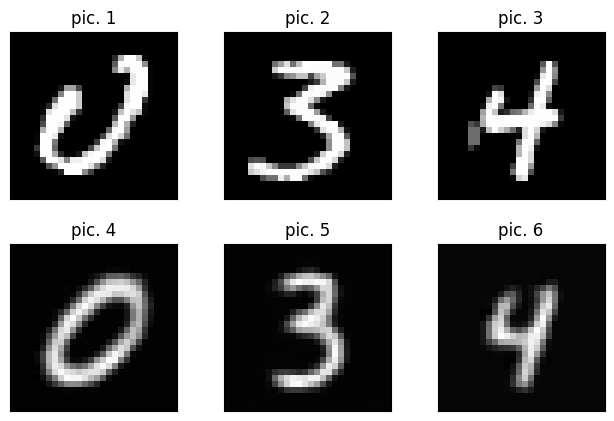

In [20]:
X_autoencoder_path = models_path / "autoencoders/"
encoder_path = X_autoencoder_path / f"X_encoder_{X_latent_dim}.pt"
decoder_path = X_autoencoder_path / f"X_decoder_{X_latent_dim}.pt"

if load_X_autoencoder:
    try:
        X_autoencoder.encoder.load_state_dict(torch.load(encoder_path))
        X_autoencoder.decoder.load_state_dict(torch.load(decoder_path))
        autoencoder_callback(X_autoencoder)
    except:
        print("The autoencoder is not found or cannot be loaded.")
        load_X_autoencoder = False
        
if not load_X_autoencoder:
    results = train_autoencoder(X_autoencoder, train_dataloader_autoencoder, test_dataloader_autoencoder, torch.nn.L1Loss(),
                                device, n_epochs=X_autoencoder_n_epochs, callback=autoencoder_callback, lr=1e-3)
    
    os.makedirs(X_autoencoder_path, exist_ok=True)
    torch.save(X_autoencoder.encoder.state_dict(), encoder_path)
    torch.save(X_autoencoder.decoder.state_dict(), decoder_path)

In [21]:
X_autoencoder.agn.enabled_on_inference = False
X_compressed = get_outputs(X_autoencoder.encoder, eval_dataloader, device).numpy()

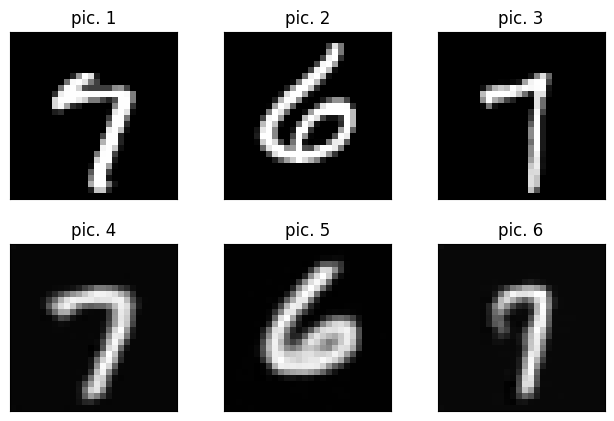

In [22]:
autoencoder_callback(X_autoencoder)

## Classifier

### Filter for plots

In [23]:
from scipy.signal import butter, filtfilt, savgol_filter
from misc.nonuniform_savgol_filter import *

def filter_data(x: np.array, errorbars: bool=True) -> np.array:
    """
    Filter the data.
    
    Parameters
    ----------
    x : np.array
        Input data.
    errorbars : bool
        Process errorbars.
        
    Returns
    -------
    np.array
        Filtered data.
    """
    
    if errorbars:
        x = np.array([item[0] for item in x])
    else:
        if type(x) is not np.array:
            x = np.array(x)
    
    # Savitzky-Golay filter.
    window_length = min(30, len(x))
    polyorder = min(4, window_length-1)
    
    y = savgol_filter(x, window_length, polyorder)
    
    #window_length = 0.5
    #polyorder = 4
    #y = nonuniform_savgol_filter(np.sort(-np.array(results["metrics"]["test_loss"])), x, window_length, polyorder)
    
    # scipy.signal.filtfilt.
    b, a = butter(8, 0.125)
    padlen = min(5, len(x)-1)
    
    y = filtfilt(b, a, y, padlen=padlen)
    
    return y

### Training

In [24]:
from misc.classifier import *
from tqdm import tqdm, trange
from sklearn.decomposition import PCA

In [25]:
classifier = MNIST_Classifier(sigma=sigma).to(device)

In [26]:
import mutinfo.estimators.mutual_information as mi_estimators

In [27]:
# Training options.
classifier_loss = torch.nn.NLLLoss()
classifier_opt = torch.optim.Adam(classifier.parameters(), lr=classifier_lr)

In [28]:
# Mutual information estimator options.

entropy_estimator_params = \
{
    'method': "KL",
    'functional_params': {'n_jobs': 16, "k_neighbours": 5}
}

compression = 'pca' # 'autoencoders', 'first_coords'

In [29]:
from collections import defaultdict

def train_classifier(classifier, classifier_loss, classifier_opt,
                     train_dataloader, test_dataloader, eval_dataloader,
                     X_compressed, entropy_estimator_params,
                     compression='pca', n_epochs: int=10,
                     filter_data: callable=None):
    
    classifier_metrics = {
        "train_loss" : [],
        "test_loss" : [],
        "train_roc_auc" : [],
        "test_roc_auc" : []
    }
    
    # Autoencoders.
    L_autoencoders = dict()
    
    # Mutual information.
    MI_X_L = defaultdict(list)
    MI_L_Y = defaultdict(list)
    filtered_MI_X_L = None
    filtered_MI_L_Y = None
    
    # Targets.
    targets = eval_dataloader.dataset.targets.detach().cpu().numpy()
    
    for epoch in range(1, n_epochs + 1):       
        # Training step.
        print(f"Epoch №{epoch}")        
        for index, batch in tqdm(enumerate(train_dataloader)):
            x, y = batch
            batch_size = x.shape[0]
            
            classifier_opt.zero_grad()
            y_pred = classifier(x.to(device))
            _loss = classifier_loss(y_pred, y.to(device))
            _loss.backward()
            classifier_opt.step()
            
        # Metrics.
        print("Calculating metrics")
        train_loss, train_roc_auc = evaluate_classifier(classifier, train_dataloader, classifier_loss, device)
        classifier_metrics["train_loss"].append(train_loss)
        classifier_metrics["train_roc_auc"].append(train_roc_auc)
        
        test_loss, test_roc_auc = evaluate_classifier(classifier, test_dataloader, classifier_loss, device)
        classifier_metrics["test_loss"].append(test_loss)
        classifier_metrics["test_roc_auc"].append(test_roc_auc)
        
        # Layers.
        print("Aquiring outputs of the layers")
        #train_outputs = get_layers(classifier, train_dataloader, device)
        #test_outputs = get_layers(classifier, test_dataloader, device)
        eval_outputs = get_layers(classifier, eval_dataloader, device)
        
        # Mutual information.
        for layer_name in eval_outputs.keys():
            this_L_latent_dim = min(L_latent_dim, torch.numel(eval_outputs[layer_name]) / eval_outputs[layer_name].shape[0])
            
            if compression == 'first_coords':
                L_compressed = eval_outputs[layer_name].numpy()
                L_compressed = np.reshape(L_compressed, (L_compressed.shape[0], -1))
                L_compressed = L_compressed[:,:this_L_latent_dim]
                
            elif compression == 'pca':
                L_compressed = eval_outputs[layer_name].numpy()
                L_compressed = np.reshape(L_compressed, (L_compressed.shape[0], -1))
                L_compressed = PCA(n_components=this_L_latent_dim).fit_transform(L_compressed)
                
            
            print(f"Estimating MI for the layer {layer_name}")            
            # (X,L)
            print("I(X;L)")
            X_L_mi_estimator = mi_estimators.MutualInfoEstimator(entropy_estimator_params=entropy_estimator_params)
            X_L_mi_estimator.fit(X_compressed, L_compressed, verbose=0)
            MI_X_L[layer_name].append(X_L_mi_estimator.estimate(X_compressed, L_compressed, verbose=0))
            
            # (L,Y)
            print("I(L;Y)")
            L_Y_mi_estimator = mi_estimators.MutualInfoEstimator(Y_is_discrete=True,
                                                                 entropy_estimator_params=entropy_estimator_params)
            L_Y_mi_estimator.fit(L_compressed, targets, verbose=0)
            MI_L_Y[layer_name].append(L_Y_mi_estimator.estimate(L_compressed, targets, verbose=0))

        
        # Plots.
        ## Metrics.
        clear_output(True)
        plt.figure(figsize=(18,4))
        for index, (name, history) in enumerate(sorted(classifier_metrics.items())):
            plt.subplot(1, len(classifier_metrics), index + 1)
            plt.title(name)
            plt.plot(range(1, len(history) + 1), history)
            plt.grid()

        plt.show();
        
        ## MI plane.
        if not filter_data is None:
            filtered_MI_X_L = {layer_name: filter_data(values) for layer_name, values in MI_X_L.items()}
            filtered_MI_L_Y = {layer_name: filter_data(values) for layer_name, values in MI_L_Y.items()}
            
        plot_MI_planes(MI_X_L, MI_L_Y, None, None)
        
    return {"metrics": classifier_metrics, "MI_X_L": MI_X_L, "MI_L_Y": MI_L_Y, "filtered_MI_X_L": filtered_MI_X_L, "filtered_MI_L_Y": filtered_MI_L_Y}

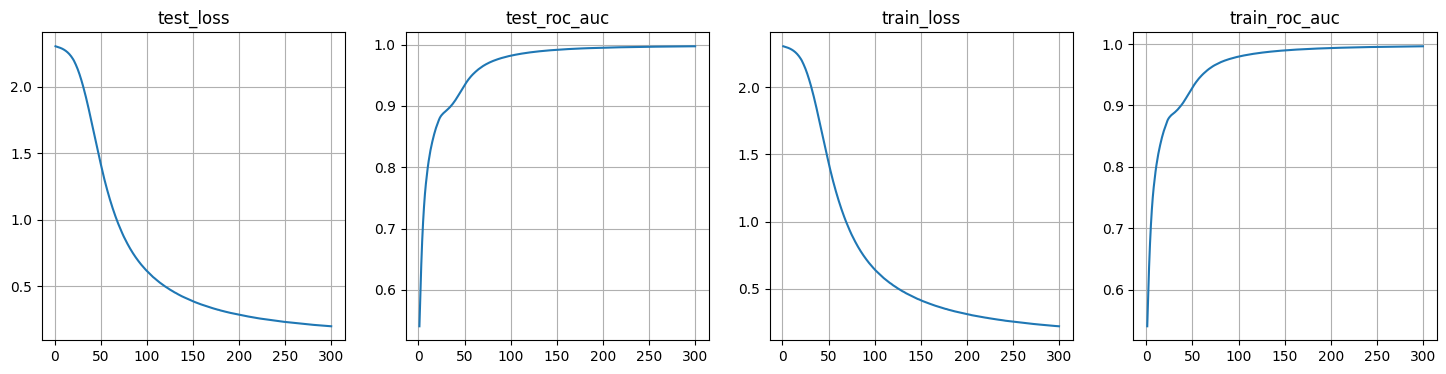

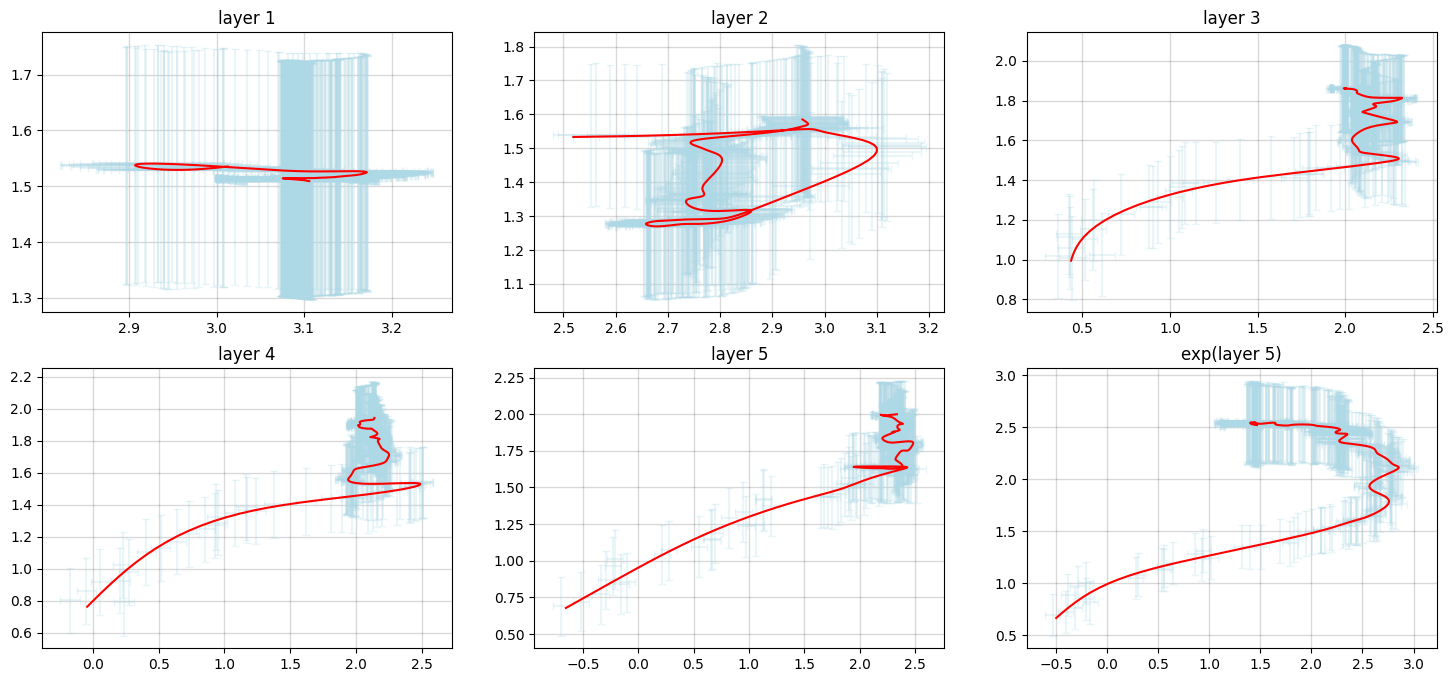

In [30]:
results = train_classifier(classifier, classifier_loss, classifier_opt,
                           train_dataloader, test_dataloader, eval_dataloader,
                           X_compressed, entropy_estimator_params,
                           compression, n_epochs=classifier_n_epochs,
                           filter_data=filter_data)

# results = train_classifier(classifier, classifier_loss, classifier_opt,
#                            train_dataloader, test_dataloader, eval_dataloader,
#                            X_compressed, entropy_estimator_params,
#                            compression, n_epochs=classifier_n_epochs,
#                            filter_data=None)

In [31]:
# results["filtered_MI_X_L"] = {layer_name: filter_data(values) for layer_name, values in results["MI_X_L"].items()}
# results["filtered_MI_L_Y"] = {layer_name: filter_data(values) for layer_name, values in results["MI_L_Y"].items()}

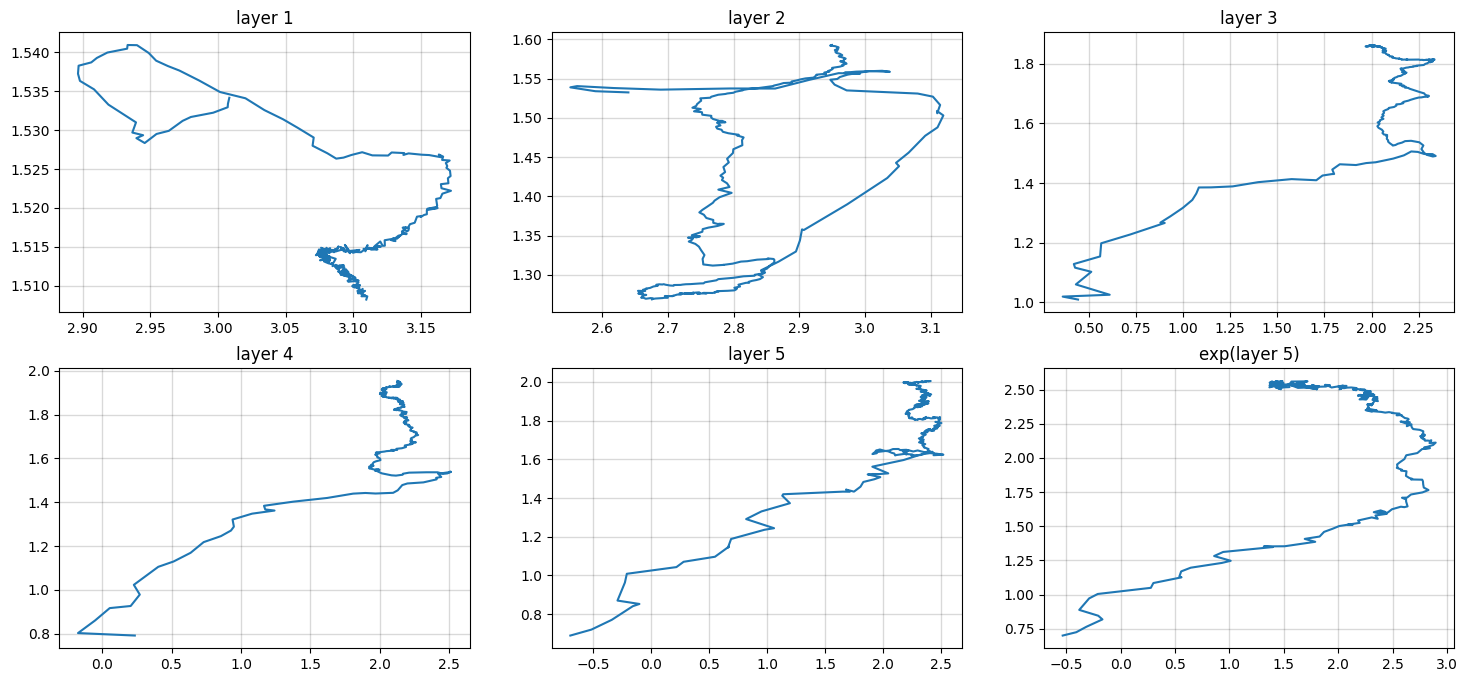

In [32]:
plot_MI_planes(results["MI_X_L"], results["MI_L_Y"], None, None)

In [33]:
# Saving all the results and settings.

settings = {
    # Autoencoder for inputs.
    "X_latent_dim": X_latent_dim,
    "X_autoencoder_n_epochs": X_autoencoder_n_epochs,
    "load_X_autoencoder": load_X_autoencoder,
    
    # Autoencoder for layers.
    "L_latent_dim": L_latent_dim,
    "L_autoencoder_n_epochs": L_autoencoder_n_epochs,
    
    # Classifier.
    "classifier_lr": classifier_lr,
    "classifier_n_epochs": classifier_n_epochs,
    "sigma": sigma,
    
    # Batch size.
    "batch_size_train": batch_size_train,
    "batch_size_test": batch_size_test,
    
    # Mutual information estimator.
    "entropy_estimator_params": entropy_estimator_params,
    "compression": compression,
}

In [36]:
results_path

WindowsPath('C:/Users/MQTyor/ai_pc/Reserch_ai/Information_Theory/SMI creation/Reproduction/MNIST experiments/Information-v3/data/mutual_information/MNIST/resuts')

In [43]:
def save_results(results: dict, settings: dict, path: Path):
    """
    Save IP experiments results (parameters, metrics, IP data, ...).
    """
    
    directory_path = path / (datetime.now().strftime("%d-%b-%Y_%H%M%S") + "/")
    directory_path.mkdir(exist_ok=True)
    
    # Metrics.
    metrics = pd.DataFrame()
    for metric_name, metric_values in results['metrics'].items():
        metrics[metric_name] = metric_values
    metrics.to_csv(directory_path / "metrics.csv", index=False)
        
    # Mutual information.
    for layer_name in results["MI_X_L"].keys():
        MI_dataframe = pd.DataFrame()
        
        MI_dataframe["I(X;L)"] = [value[0] for value in results["MI_X_L"][layer_name]]
        MI_dataframe["I(L;Y)"] = [value[0] for value in results["MI_L_Y"][layer_name]]
        
        MI_dataframe["std I(X;L)"] = [value[1] for value in results["MI_X_L"][layer_name]]
        MI_dataframe["std I(L;Y)"] = [value[1] for value in results["MI_L_Y"][layer_name]]
        
        MI_dataframe["filtered I(X;L)"] = results["filtered_MI_X_L"][layer_name]
        MI_dataframe["filtered I(L;Y)"] = results["filtered_MI_L_Y"][layer_name]
        
        MI_dataframe.to_csv(directory_path / f"{layer_name}.csv", index=False)
        
    # Settings.
    with open(directory_path / "settings.json", 'w') as outfile:
        json.dump(settings, outfile)

In [44]:
save_results(results, settings, results_path)